In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools
from functools import reduce
from IPython import display
from IPython.display import Image

In [3]:
#twitter embeding https://github.com/jupyter/notebook/issues/2790
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

re = ("""
<blockquote class="twitter-tweet"><p lang="und" dir="ltr"><a href="https://twitter.com/hashtag/FraudNewsCNN?src=hash&amp;ref_src=twsrc%5Etfw">#FraudNewsCNN</a> <a href="https://twitter.com/hashtag/FNN?src=hash&amp;ref_src=twsrc%5Etfw">#FNN</a> <a href="https://t.co/WYUnHjjUjg">pic.twitter.com/WYUnHjjUjg</a></p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/881503147168071680?ref_src=twsrc%5Etfw">July 2, 2017</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")
fav = ("""<blockquote class="twitter-tweet"><p lang="en" dir="ltr">A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/1157345692517634049?ref_src=twsrc%5Etfw">August 2, 2019</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>""")

### Background
A while back I read a post by a reddit user who compared President trump's Tweets to price changes in stocks.

The reddit user would take tweets in which Trump talked about trade negotiations with China and stock values of companies that relied heavily on production in China like computer hardware manfacturers, clothing retailers, etc. 

They noticed that everytime Trump tweeted negatively about trade negotations there would be decline in the stock's value the following trading day and vice-versa if Trump tweeted something positive about trade negotations. Which leads me to my capstone project idea.


### Capstone Project Requirements:
**Hypothesis:** If Trump tweets something negative about the economy then we should see a decrease in value of major indexes and certain stocks.

**Goals and Success Metrics:**

-identify which words are most likely to cause a change in the chosen stock/index value and whether they have a negative or positive impact on the stock/index.

-be able to predict and measure the % change caused by the tweet in the stock/index value.

**Risks or Limiations:**

-Swings in financial markets are caused by multiple variables acting on it so while we might see a strong correlation between one of Trump's tweets and the change in a stock/index value. The change in value could be caused by something completely different.

-black swan events occuring in markets

-plenty of factors go into determining the value of stock so isolating the effect of Trump's tweets on the stock/index may prove to be difficult.

# Trump Twitter EDA
{{Image("./data/trump_twitter_profile.png")}}

In [4]:
tweets = pd.read_excel('./data/2020.05.11_trump_tweets.xlsx')
#http://www.trumptwitterarchive.com/about
#only includes tweets after Donald Trump was inaugurated in January 20, 2017
#the id_str column seems to be a 19 digit unique identifier for each tweet. It could also be meta data from the scrapping
#tweets = tweets.drop(columns='id_str')
#converts the created_at column to a datetime object for easier timeseries maniuplation
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
#tweets.head(5)
tweets.columns

Index(['source', 'text', 'created_at', 'retweet_count', 'favorite_count',
       'is_retweet', 'id_str'],
      dtype='object')

### Below is a quick explanation of each of the feature for the tweets datasets:

<br>**Source**: What device was the tweet created from.

**Text**: The tweet itself in string format.

**Created_at**: The time the tweet was tweeted.

**retweet_count**: # of times the tweet was retweeted by others.

**favorite-count**: $ of times the tweet was favorited.

**is_retweet**: boolean value dictating whether the tweet is a retweet or created by Trump himself. 1 for retweet, 0 for original.

**id_str**: A 19 digit integer that seems to be a unique id for each tweet


## Summary statistics on President Trump's tweets and Twitter usage

In [5]:
trump_text = " ".join(tweet for tweet in tweets['text'])
trump_text = trump_text.lower()
print("Trump has tweeted " + str(format(tweets.shape[0],",d")), "times since taking office in January 20, 2017.")
print("Trump has tweeted a total of {} words.".format(format(len(trump_text),",d")))
print("Trump's tweets have been retweeted " + str(format(int(tweets['retweet_count'].sum()),",d")), "times and favorited "+ str(format(int(tweets['favorite_count'].sum()),",d")), "times.")
print("On average, Trump's tweets are retweeted " + str(format(int(tweets['retweet_count'].mean()),",d")) + " times and favorited " + str(format(int(tweets['favorite_count'].mean()),",d")), "times" )
print("Trump has retweeted something " + str(format(int(tweets['is_retweet'].sum()),",d")), "times.")

Trump has tweeted 17,883 times since taking office in January 20, 2017.
Trump has tweeted a total of 2,800,931 words.
Trump's tweets have been retweeted 316,051,483 times and favorited 1,051,428,160 times.
On average, Trump's tweets are retweeted 17,675 times and favorited 58,801 times
Trump has retweeted something 3,908 times.


Trump's most retweeted tweet

In [6]:
#returns columns with the row with the highest value in retweet_count
tweets.loc[tweets['retweet_count'].idxmax()]
Tweet(re)

Trump's most favorited tweet

In [7]:
#returns columns with the row with the highest value in favorite_counts
tweets.loc[tweets['favorite_count'].idxmax()]
Tweet(fav)

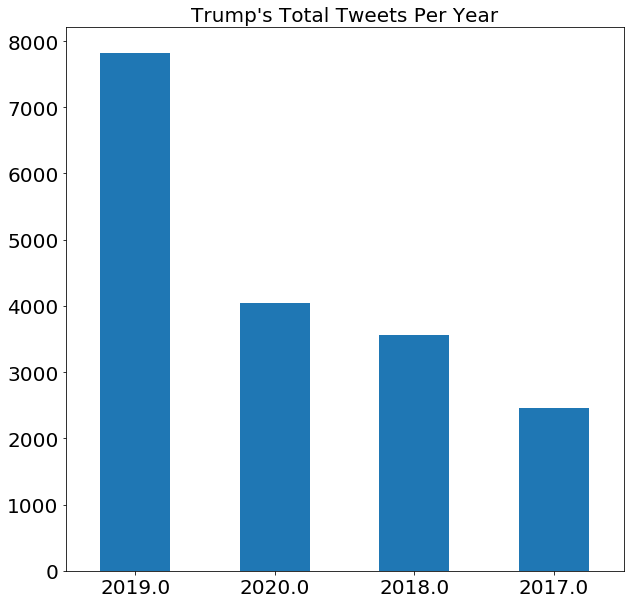

In [8]:
ax = tweets['created_at'].dt.year.value_counts().plot(kind='bar',figsize=(10,10),rot=0);
ax.set_title("Trump's Total Tweets Per Year",fontsize=20)
ax.tick_params(labelsize=20)
#from the graph below, trump tweeted the most in 2019.

In [9]:
yearly_tweet_avg = tweets['created_at'].dt.year.value_counts()/365
for value, year in zip(yearly_tweet_avg,yearly_tweet_avg.index):
    print("in {} Trump averaged {} tweets a day.".format(round(year),round(value)))

in 2019 Trump averaged 21 tweets a day.
in 2020 Trump averaged 11 tweets a day.
in 2018 Trump averaged 10 tweets a day.
in 2017 Trump averaged 7 tweets a day.


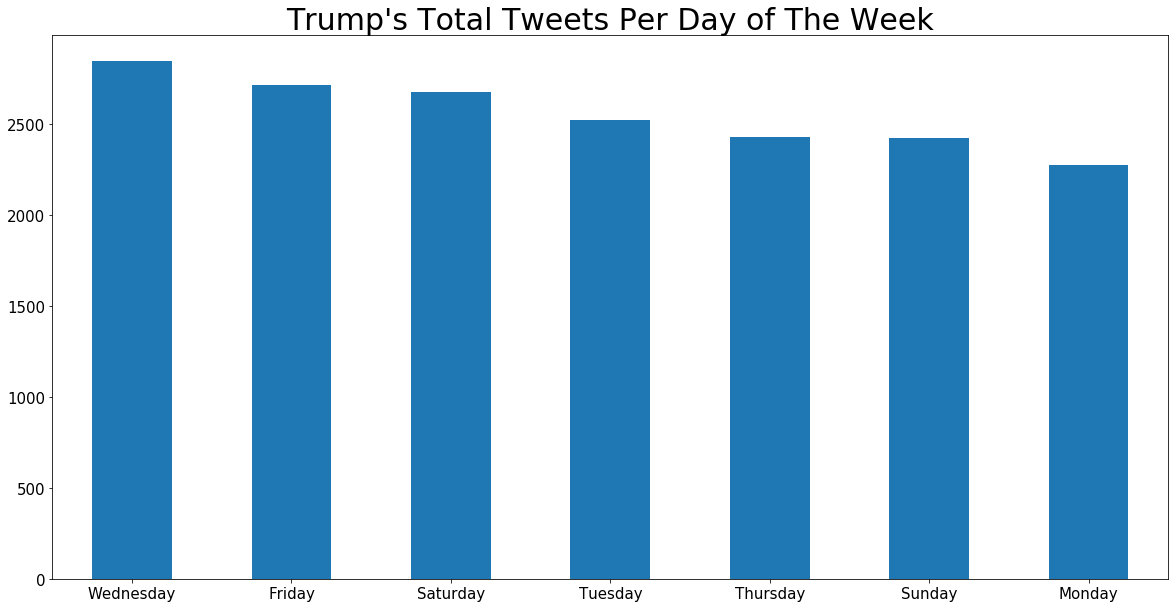

In [10]:
ax = tweets['created_at'].dt.dayofweek.value_counts().plot(kind='bar',figsize=(20,10),rot=0)
#The day of the week with Monday=0, Sunday=6.
#set_ticklabels to rename the days the week for better clarity
ax.set_xticklabels(['Wednesday','Friday','Saturday','Tuesday','Thursday','Sunday','Monday'],fontsize=10);
ax.set_title("Trump's Total Tweets Per Day of The Week",fontsize=30)
ax.tick_params(labelsize=15)

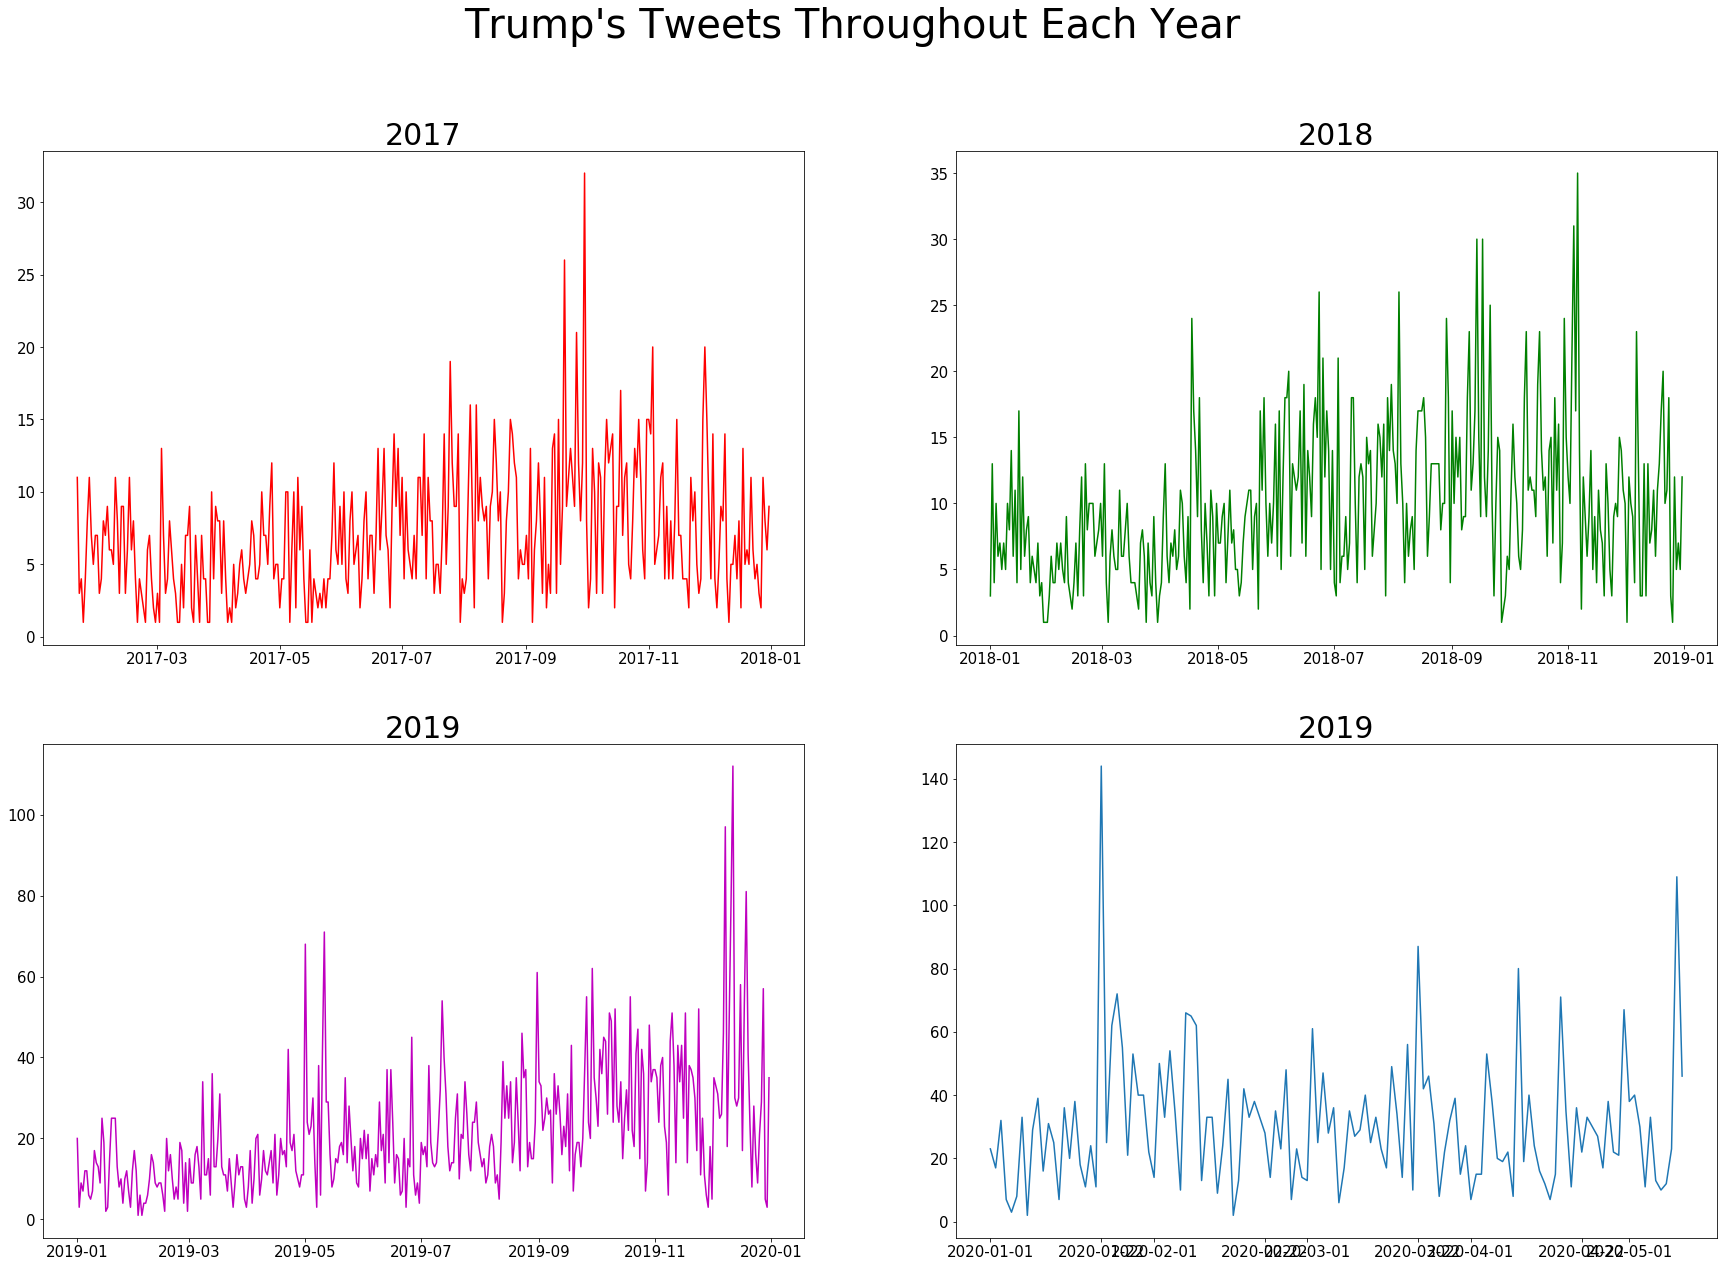

In [11]:
tweet2017 = tweets[tweets['created_at'].dt.year == 2017.0]

tweet2018 = tweets[tweets['created_at'].dt.year == 2018.0]

tweet2019 = tweets[tweets['created_at'].dt.year == 2019.0]

tweet2020 = tweets[tweets['created_at'].dt.year == 2020.0]


fig, axs = plt.subplots(2, 2)

tweet2017['created_at'].dt.date.value_counts().plot(figsize=(30,20),ax=axs[0,0],fontsize=15,color='r'); axs[0,0].set_title('2017',fontsize=30)
tweet2018['created_at'].dt.date.value_counts().plot(ax=axs[0,1],fontsize=15,color='g'); axs[0,1].set_title('2018',fontsize=30)
tweet2019['created_at'].dt.date.value_counts().plot(ax=axs[1,0],fontsize=15,color='m'); axs[1,0].set_title('2019',fontsize=30)
tweet2020['created_at'].dt.date.value_counts().plot(ax=axs[1,1],fontsize=15); axs[1,1].set_title('2019',fontsize=30)
fig.suptitle("Trump's Tweets Throughout Each Year",fontsize=40);
#No matter the year it shows that throughout the year, Trump is pretty consistent in his tweeting pattern and usage

## Handling Null Values

In [12]:
tweets.isnull().sum()

source             0
text               0
created_at         2
retweet_count      2
favorite_count     2
is_retweet        60
id_str             2
dtype: int64

The majority of missing values are from the is_retweet column which isn't really necessary for the analysis and ML prediction. The other 2 nulls are highly unlikely to skew the data/analysis.

The person who compiled the Trump's Twitter Archive site, Brendan Brown, stated:

<i>"I am missing approximately 4000 tweets. I also don't have any tweets he deleted prior to September 2016."</i>

with 17,000 tweets already. I think there's sufficient date here already and if Trump deleted a majority of those missing tweets then I wouldn't be able to find them via twitter anyways. 

More information on the dataset can be found [here.](http://www.trumptwitterarchive.com/about)

## Trump's Tweet Text Analysis

In [13]:
#a list of common english stop words from http://xpo6.com/list-of-english-stop-words/
#added in some of my own values to account for jargon/slang and other stopwords that I felt were missing.
stopwords = ["ha","wa","thi","amp","&amp;","http","https","rt","-","a", "about", "above", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount",  "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as",  "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred","i", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the"]

In [14]:
#function taken from: https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-12.php
#generates a dictionary from a string with the key being the word and it's corresponding value being the its occurence count
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

trump_dict = word_count(trump_text)
print(len(trump_dict))

41954


In [15]:
#loop to remove stopwords from the trump's tweets
for key in stopwords:
    if key in trump_dict:
        del trump_dict[key]
print(len(trump_dict))
#the number of keys dropped by 280 which means it the loop worked

41665


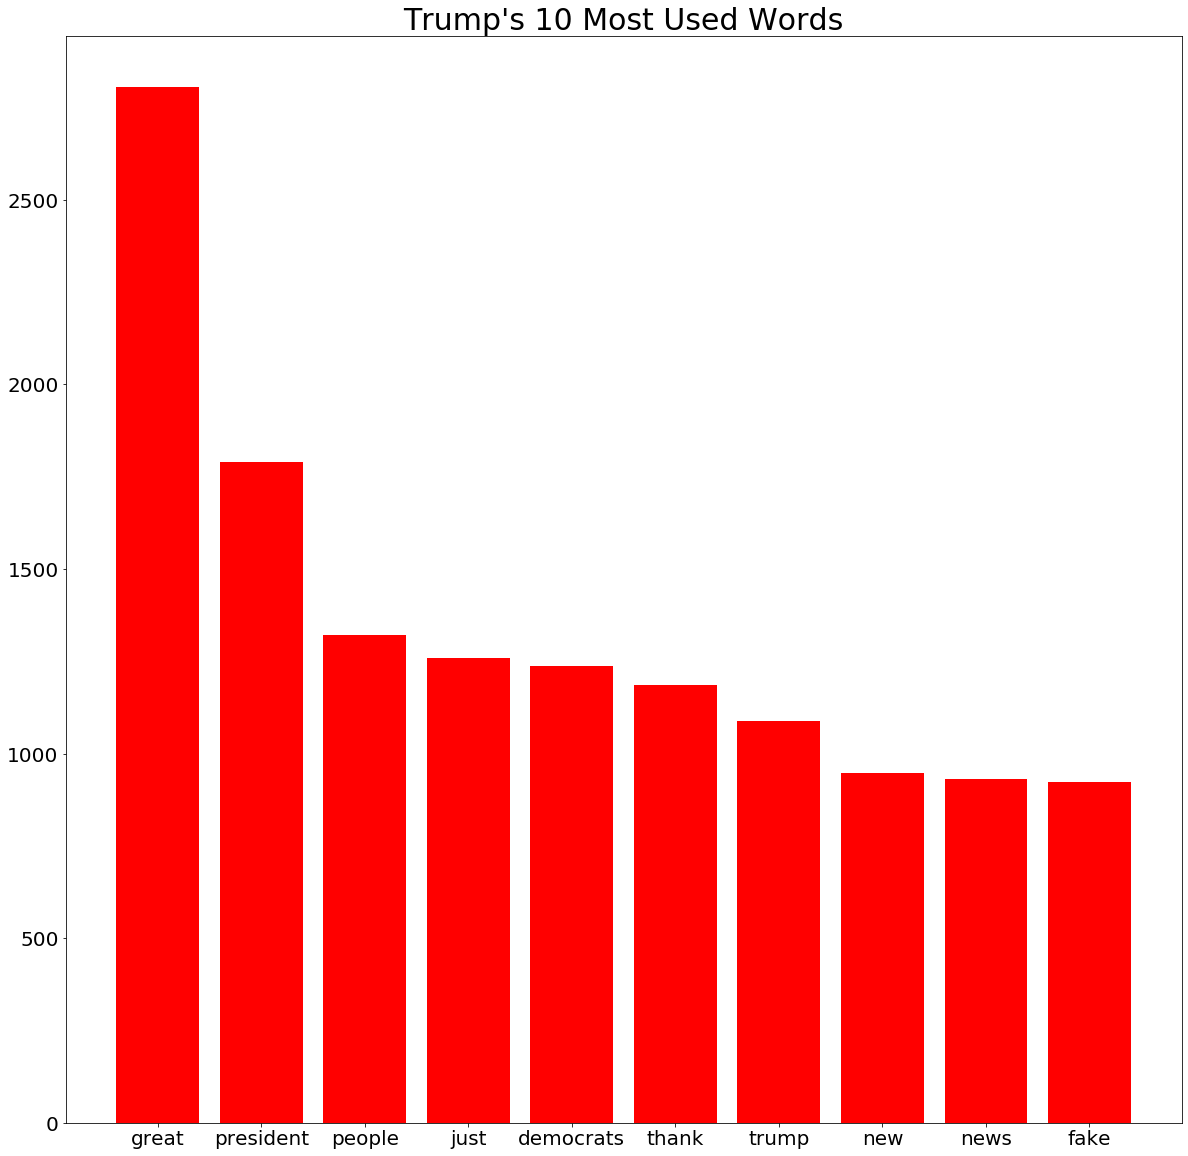

In [32]:
y = sorted(trump_dict.values(),reverse=True)[:10]
x = sorted(trump_dict, key=trump_dict.get,reverse=True)[:10]
plt.figure(figsize=(20,20));
plt.title("Trump's 10 Most Used Words",fontsize=30)
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.bar(x, y,color='r')
plt.show()

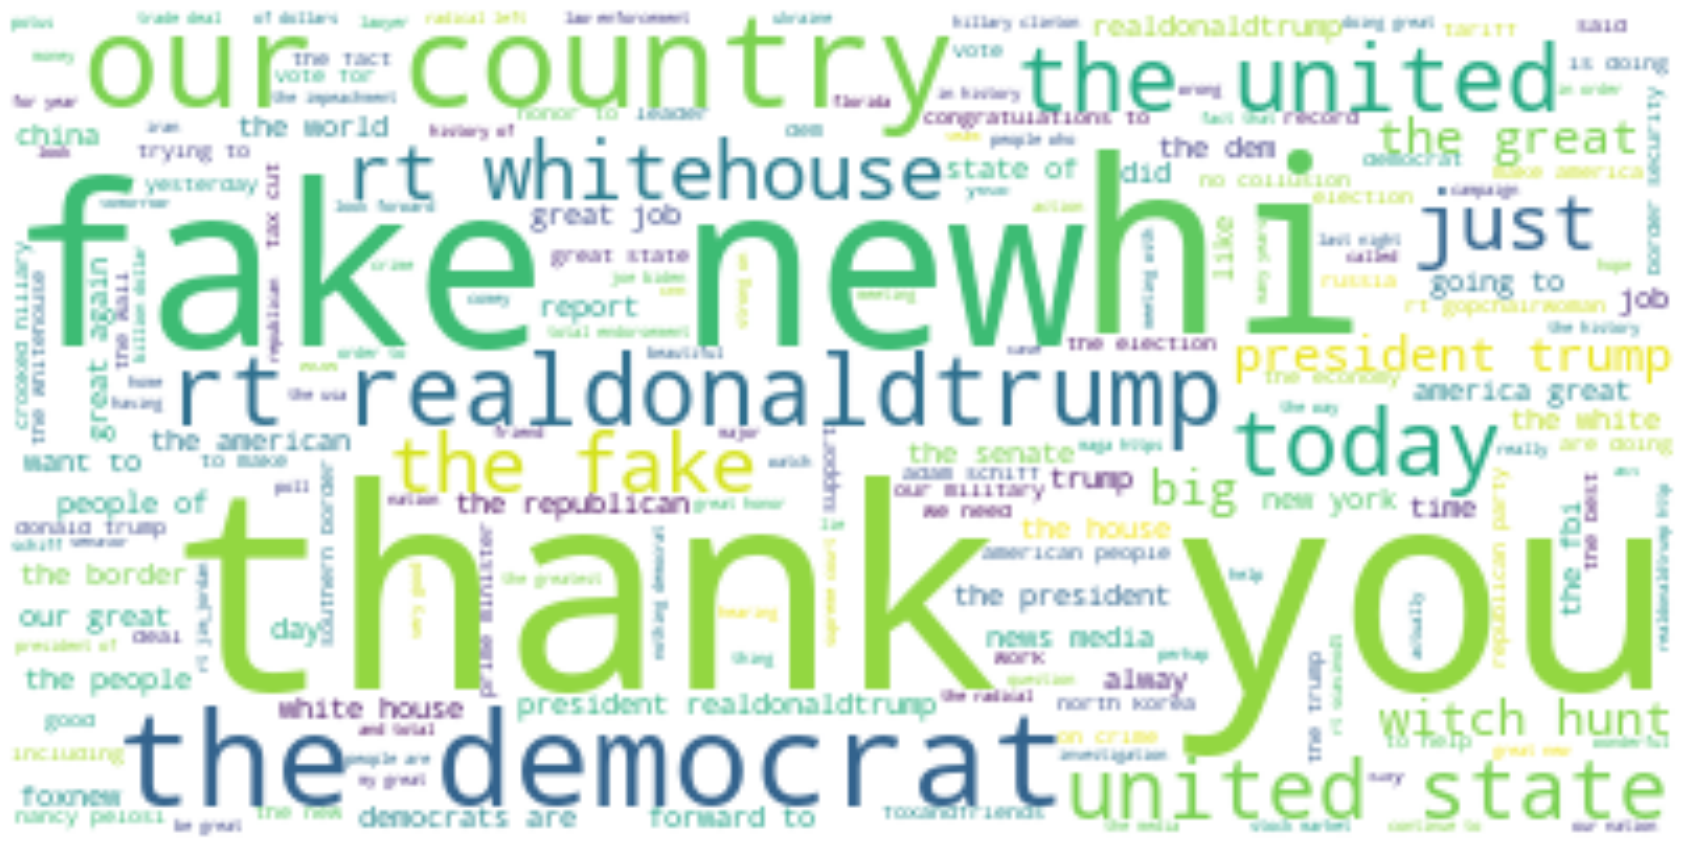

In [17]:
#world cloud tutorial from: https://www.datacamp.com/community/tutorials/wordcloud-python
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(trump_text)
plt.figure(figsize=[30,30])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Stock Indexes EDA

In [50]:
#all datasets were taken from yahoo finance
#dataset includes records for 05/11/2015-05/11/2020
#reads in the dow jones industrial average ticker
dow = pd.read_csv('./data/^DJI.csv')
#reads in the nasdaq composite index ticker
nasdaq = pd.read_csv('./data/^IXIC.csv')
#reads in the S&P 500 index ticker
sp500 = pd.read_csv('./data/^GSPC.csv')
#reads in the Real Estate Select Sector SPDR Fund ticker
spreal = pd.read_csv('./data/XLRE.csv')
#reads in the Technology Select Sector SPDR Fund ticker
sptech = pd.read_csv('./data/XLK.csv')
#reads in teh Health Care Select Sector SPDR Fund ticker
sphealth = pd.read_csv('./data/XLV.csv')
print(dow.shape)
print(nasdaq.shape)
print(sp500.shape)
#the Real Estate Select Sector SPDR Fund Ticker was created in Oct 2015 hence the lower # of records compared to the other indexes
print(spreal.shape)
print(sptech.shape)
print(sphealth.shape)

(2846, 7)
(2846, 7)
(2846, 7)
(1154, 7)
(2846, 7)
(2846, 7)


The ticker datasets all have the same format and column headers.

### Below is a quick explanation of each of the feature for the ticker datasets:

<br>**Date**: Date of the trading day.

**Open**: The price at which a security first trades upon the opening of a trading day.

**High**: The highest recorded trading price of the security for the corresponding date.

**Low**: The lowest recorded trading price of the security for the corresponding date.

**Close**: The price at which the security traded last before the end of the trading day.

**Adj Close**: An adjusted version of the Close price that factors in that might affect the stock price after market close. Gives a more accurate 

**Volume**: The amount of times the security was traded throughout the day.

### Sampling
The dataset pulled from Yahoo! Finance website includes all values for each trading day since January 20, 2009 the date of Barack Obama's inauguration and doesn't contain any null values. The dataset is then split into two DFs corresponding to Obama's term and Trump's term


In [51]:
#renames every column in each dataframe with the variable name _ feature name except for the Date column
dow.rename(lambda x: 'dow_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
nasdaq.rename(lambda x: 'nasdaq_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
sp500.rename(lambda x: 'sp500_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
spreal.rename(lambda x: 'spreal_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
sptech.rename(lambda x: 'sptech_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
sphealth.rename(lambda x: 'sphealth_' + str(x).lower() if x != 'Date' else x, axis=1,inplace=True)
#creates a list of the seperate dataframes
tickers = [dow,nasdaq,sp500,spreal,sptech,sphealth]
# the reduce function from functools applys the lambda function to all DFs in the tickers list. the lamba function merges all the dfs and how argument tells the merge to keep values in even though there's not a match. 
ticker_agg = reduce(lambda left,right: pd.merge(left,right,on='Date',how='outer'), tickers)
ticker_agg['Date'] = pd.to_datetime(ticker_agg['Date'])

ticker_agg.head(2)

,Date,dow_open,dow_high,dow_low,dow_close,dow_adj close,dow_volume,nasdaq_open,nasdaq_high,nasdaq_low,...,sptech_low,sptech_close,sptech_adj close,sptech_volume,sphealth_open,sphealth_high,sphealth_low,sphealth_close,sphealth_adj close,sphealth_volume
0,2009-01-20,8279.629883,8291.980469,7939.930176,7949.089844,7949.089844,419200000,1520.760010,1521.849976,1440.859985,...,14.30,14.33,11.911844,16858100,26.01,26.309999,25.410000,25.430000,20.802702,8967000
1,2009-01-21,7949.169922,8243.549805,7936.189941,8228.099609,8228.099609,410040000,1466.400024,1507.520020,1444.900024,...,14.45,15.02,12.485409,5862400,25.77,26.059999,25.280001,25.969999,21.244440,6294300


In [52]:
ticker_agg['dow_%'] = ((ticker_agg['dow_close']-ticker_agg['dow_open'])/ticker_agg['dow_open'])
ticker_agg['nasdaq_%'] = ((ticker_agg['nasdaq_close']-ticker_agg['nasdaq_open'])/ticker_agg['nasdaq_open']);
ticker_agg['sp500_%'] = ((ticker_agg['sp500_close']-ticker_agg['sp500_open'])/ticker_agg['sp500_open']);
ticker_agg['spreal_%'] = ((ticker_agg['spreal_close']-ticker_agg['spreal_open'])/ticker_agg['spreal_open']);
ticker_agg['sptech_%'] = ((ticker_agg['sptech_close']-ticker_agg['sptech_open'])/ticker_agg['sptech_open']);
ticker_agg['sphealth_%'] = ((ticker_agg['sphealth_close']-ticker_agg['sphealth_open'])/ticker_agg['sphealth_open']);
ticker_agg.head(5)

,Date,dow_open,dow_high,dow_low,dow_close,dow_adj close,dow_volume,nasdaq_open,nasdaq_high,nasdaq_low,...,sphealth_low,sphealth_close,sphealth_adj close,sphealth_volume,dow_%,nasdaq_%,sp500_%,spreal_%,sptech_%,sphealth_%
0,2009-01-20,8279.629883,8291.980469,7939.930176,7949.089844,7949.089844,419200000,1520.760010,1521.849976,1440.859985,...,25.410000,25.430000,20.802702,8967000,-0.039922,-0.052540,-0.052281,NaN,-0.038900,-0.022299
1,2009-01-21,7949.169922,8243.549805,7936.189941,8228.099609,8228.099609,410040000,1466.400024,1507.520020,1444.900024,...,25.280001,25.969999,21.244440,6294300,0.035089,0.027735,0.041486,NaN,0.023161,0.007761
2,2009-01-22,8224.429688,8224.830078,7957.140137,8122.799805,8122.799805,420040000,1470.849976,1492.469971,1444.079956,...,25.600000,26.080000,21.334421,4778900,-0.012357,-0.003644,-0.014576,NaN,-0.001361,0.010070
3,2009-01-23,8108.790039,8152.589844,7909.029785,8077.560059,8077.560059,370510000,1440.780029,1495.270020,1434.079956,...,25.610001,26.080000,21.334421,4563300,-0.003851,0.025340,0.011908,NaN,0.033310,0.007728
4,2009-01-26,8078.040039,8231.679688,8023.160156,8116.029785,8116.029785,316720000,1479.979980,1514.380005,1470.810059,...,25.799999,25.940001,21.219902,6881000,0.004703,0.006405,0.004889,NaN,0.006008,-0.008789


In [53]:
#the squeeze method takes out the first row of values and turns them into an array. The array is then subtracted from every row of the dataframe
diff = ticker_agg - ticker_agg.head(1).values.squeeze()
diff[diff.columns[diff.columns.to_series().str.contains('_close')]].tail(1)

,dow_close,nasdaq_close,sp500_close,spreal_close,sptech_close,sphealth_close
2845,16382.230469,7680.460328,2124.580078,NaN,80.449999,73.980004


In [54]:
ticker_agg[ticker_agg.columns[ticker_agg.columns.to_series().str.contains('%')]].mean()
#the average % change per day in all the indexes' values

dow_%         0.000395
nasdaq_%      0.000396
sp500_%       0.000389
spreal_%     -0.000029
sptech_%      0.000303
sphealth_%    0.000253
dtype: float64

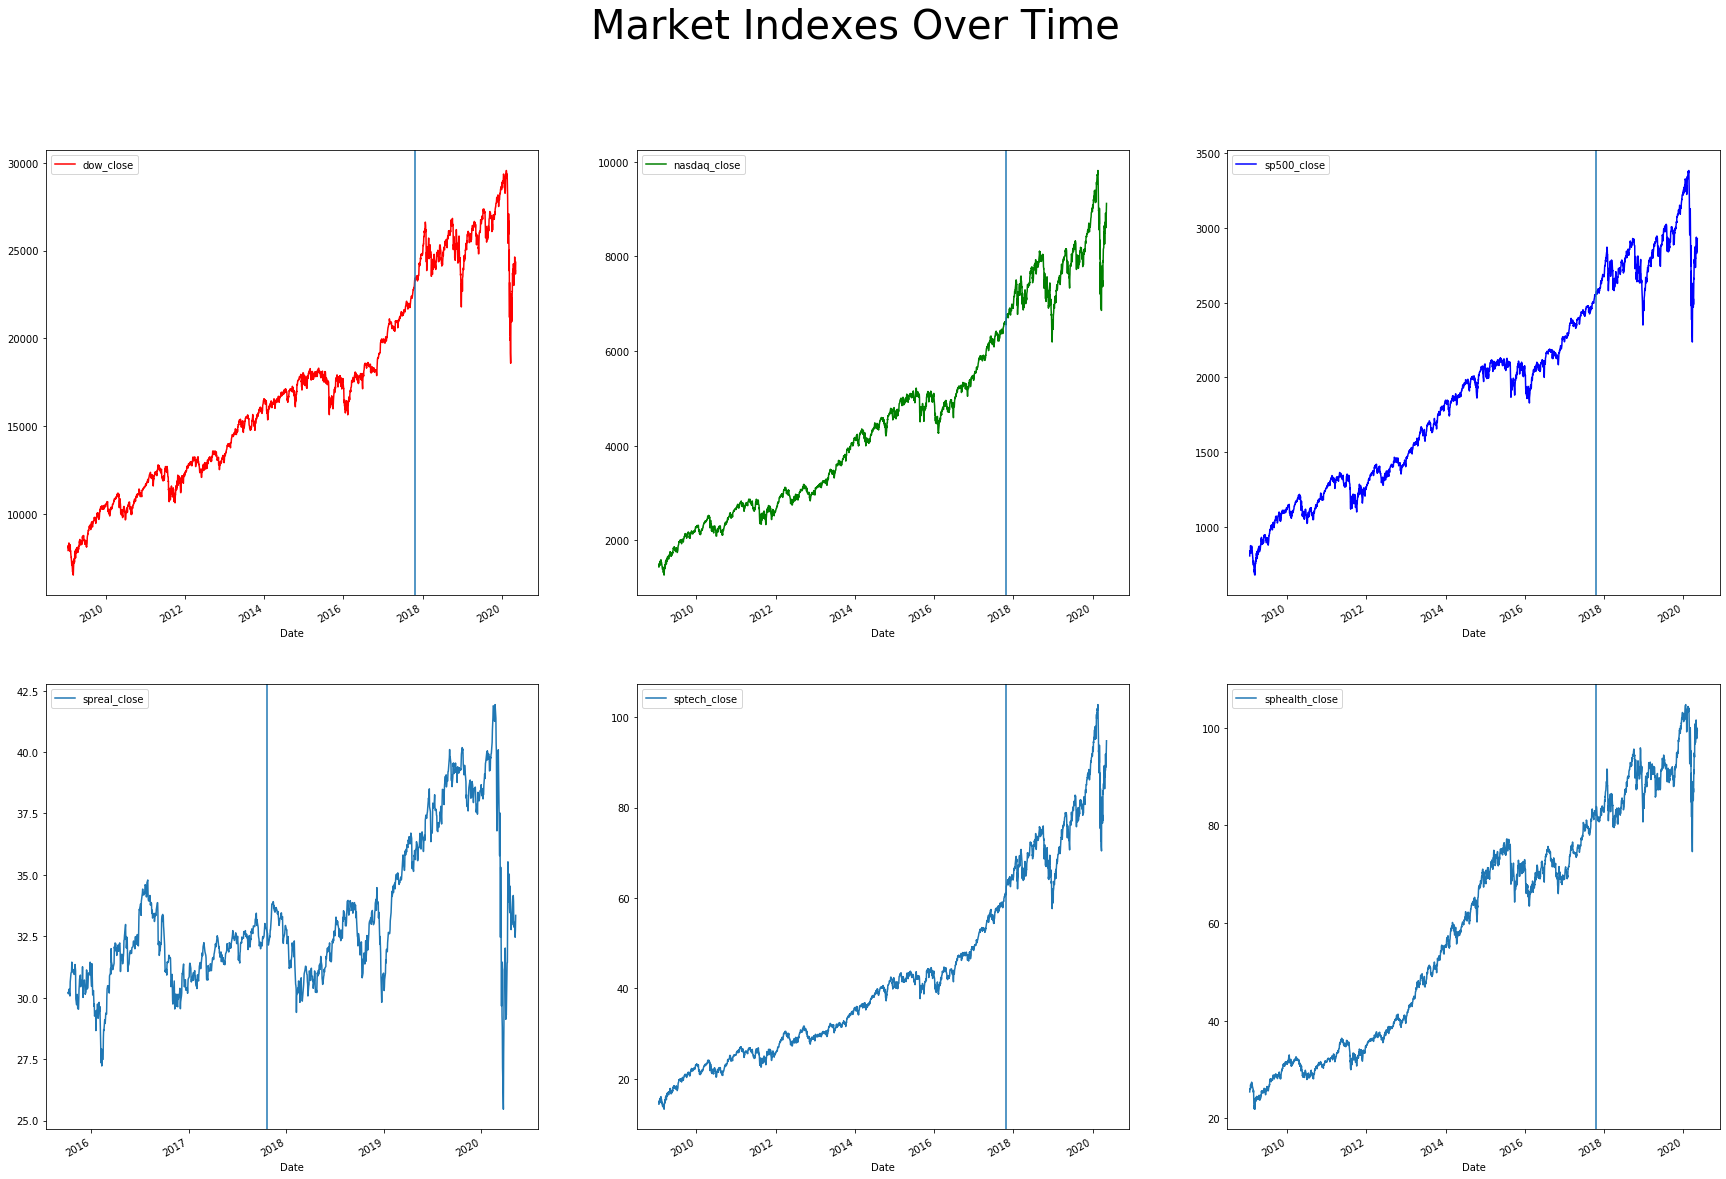

In [63]:
fig, axs = plt.subplots(2, 3)
ticker_agg.plot(kind='line',x='Date',y='dow_close',ax=axs[0,0],figsize=(30,20),color='r')
ticker_agg.plot(kind='line',x='Date',y='nasdaq_close',ax=axs[0,1],color='g')
ticker_agg.plot(kind='line',x='Date',y='sp500_close',ax=axs[0,2],color='b')
ticker_agg.plot(kind='line',x='Date',y='spreal_close',ax=axs[1,0])
ticker_agg.plot(kind='line',x='Date',y='sptech_close',ax=axs[1,1])
ticker_agg.plot(kind='line',x='Date',y='sphealth_close',ax=axs[1,2])
axs[0,0].axvline('2017-10-20')
axs[0,1].axvline('2017-10-20')
axs[0,2].axvline('2017-10-20')
axs[1,0].axvline('2017-10-20')
axs[1,1].axvline('2017-10-20')
axs[1,2].axvline('2017-10-20')
fig.suptitle("Market Indexes Over Time",fontsize=40);
plt.show()
#From the graphs we can see that all these indexes saw an immediate increase once Trump took office

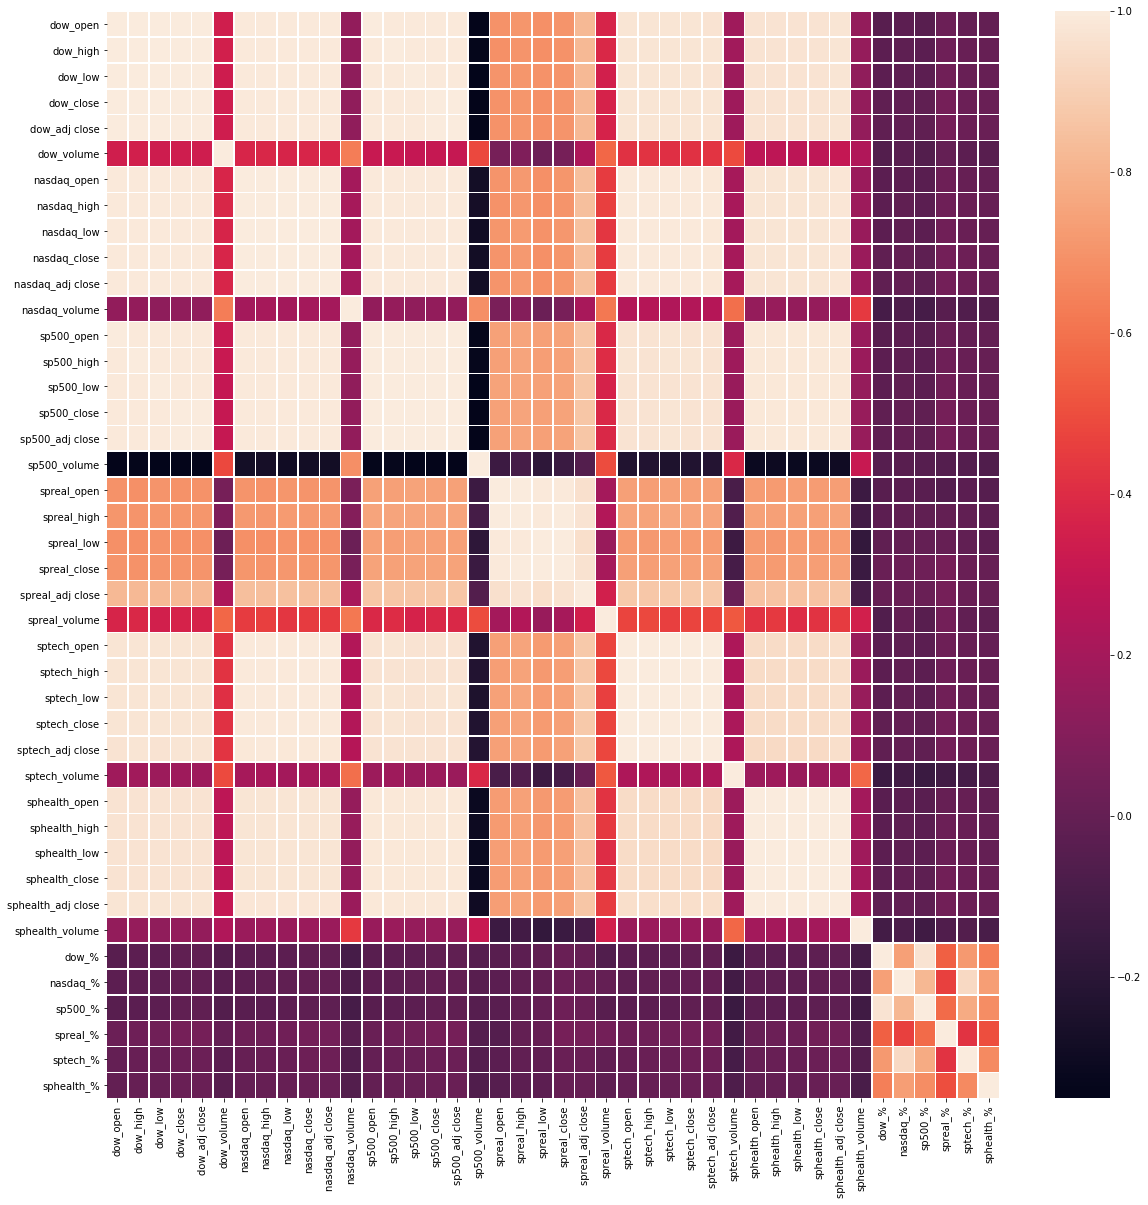

In [24]:
#Visual check to see the correlation between all the features/Indexes
fig, ax = plt.subplots(1,figsize=(20,20))
ax = sns.heatmap(ticker_agg.corr(),linewidths=.5)
#so naturally many of the indexes have very high correlation do to the fact they're comprised of many of the same securities
#there shouldn't be a Multicollinearity since these are the variables we're trying to measure

## President Trump's Term

In [25]:
#created copies of the ticker DF to prevent chaining issues
pres_trump = ticker_agg.copy()
pres_trump = pres_trump.loc[ticker_agg['Date'] >= '2017-01-20'];
#641 trading days for Trump so far
pres_trump.shape

(831, 43)

In [26]:
diff = pres_trump - pres_trump.head(1).values.squeeze()
diff[diff.columns[diff.columns.to_series().str.contains('_close')]].tail(1)
#Since the start Trump's presidency, all the indexes have seen a positive increase in value

,dow_close,nasdaq_close,sp500_close,spreal_close,sptech_close,sphealth_close
2845,4504.070313,3565.990235,658.48999,2.449998,44.98,29.570008


In [27]:
pres_trump[pres_trump.columns[pres_trump.columns.to_series().str.contains('%')]].mean()
#the average % change per day in all the indexes' values during Trump's Presdiency 
#all of them ar positive so it may add some evidence to support Trump's ability to improve the economy?

dow_%         0.000111
nasdaq_%      0.000300
sp500_%       0.000087
spreal_%      0.000246
sptech_%      0.000548
sphealth_%    0.000410
dtype: float64

## President Obama's Term

In [28]:
pres_obama = ticker_agg.copy()
pres_obama = pres_obama.loc[ticker_agg['Date'] < '2017-01-20'];
#2205 Trading days for Oba,
pres_obama.shape

(2015, 43)

In [29]:
diff = pres_obama - pres_obama.head(1).values.squeeze()
diff[diff.columns[diff.columns.to_series().str.contains('_close')]].tail(1)
#During Obama's term all the values of the indexes have increased besides spreal since it did not exist until Oct-2015.

,dow_close,nasdaq_close,sp500_close,spreal_close,sptech_close,sphealth_close
2014,11783.310547,4099.220093,1458.46997,NaN,35.199999,44.589997


In [30]:
pres_obama[pres_obama.columns[pres_obama.columns.to_series().str.contains('%')]].mean()
#excluding spreal it seems that during Obama's term the major indexes had a greater increase per day compared to Trump's Term. But we do see a decrease in the health and tech indexes.
#This is most likely due to Obama push for universal healthcare and the tech industry still growing

dow_%         0.000512
nasdaq_%      0.000436
sp500_%       0.000514
spreal_%     -0.000739
sptech_%      0.000202
sphealth_%    0.000188
dtype: float64

# Shortcomings, Assumptions, & Next-steps

## Shortcomings:

-The Market is influenced by 100,000s of different variables. Even if we do see a correlation in between a tweet and a gain in the index it could be due to different cause.

-Trump tweets are sometimes incoherent or contain mispellings. Need to account for these occurences when using Natural Language Processing 

-Might be better to measure Trump's influence on individual stocks rather than indexes

-The stocks are tracked daily but may prove better to track hourly in order to see isolate Trump's influence on the index/stock immediately after he tweets

## Assumption:

-I'm assuming the markets moves freely and indepdently and behavorial economics apply

-Donald Trump will continue to tweet at rate similar to what he is currently doing

-No other future disaster that cause mass influxes in the stock market (i.e. like corona virus)

-All the data pulled from the websites are accurately recorded


## Next steps:

-Apply Natural Language Processing to Trump's tweets

-Add a normalization factor if necessary?

-split the datasets to train and test sets

-apply a machine learning model